In [1]:
import evaluate
import yaml
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint as print

/home/ubuntu/chronos/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/chronos/venv/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
chronos_model_id  = "amazon/chronos-t5-small"
device = "cuda:0"
torch_dtype = "bfloat16"
batch_size = 32
num_samples = 20

CONFIG_FILE = "/home/ubuntu/timeseries-modeling/chronos-forecasting/scripts/evaluation/configs/bike-july-zero-shot.yaml"

pipeline = evaluate.ChronosPipeline.from_pretrained(
    chronos_model_id,
    device_map=device,
    torch_dtype=torch_dtype,
)

# Load backtest configs
with open(CONFIG_FILE) as fp:
    backtest_configs = yaml.safe_load(fp)
config = backtest_configs[0]
print(config)

{'hf_repo': '/home/ubuntu/timeseries-modeling/data/bike_day_july',
 'name': 'default',
 'num_rolls': 1,
 'offset': -31,
 'prediction_length': 31}


In [3]:
test_data = evaluate.load_and_split_dataset(backtest_config=config)

sample_forecasts = evaluate.generate_sample_forecasts(
    test_data.input,
    pipeline=pipeline,
    prediction_length=config["prediction_length"],
    batch_size=batch_size,
    num_samples=num_samples,
    temperature=None,
    top_k=None,
    top_p=None,
)

1it [00:00,  1.19it/s]


In [4]:
training_data = [item for item in test_data]

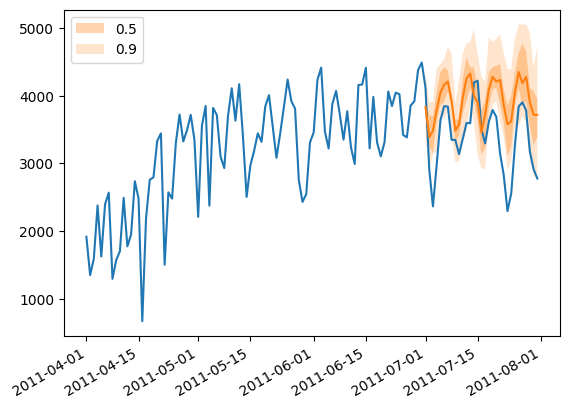

In [5]:
training_data_length = len(training_data[1][0]['target'])
training_data_start = training_data[1][1]['start'].to_timestamp() - pd.DateOffset(days=training_data_length)
dates = pd.date_range(start=training_data_start, periods=config['prediction_length']+training_data_length, freq='D')

fig, ax = plt.subplots()

ax.plot(dates, np.append(training_data[1][0]['target'], training_data[1][1]['target']))
sample_forecasts[1].plot(ax=ax, show_label=True)
fig.autofmt_xdate()
plt.legend()